In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Preparing the dataset

In [2]:
df = pd.read_csv("earthquake_alert_balanced_dataset.csv")

df = df.dropna().reset_index(drop=True)

features = ['magnitude', 'depth', 'cdi', 'mmi', 'sig']
target = 'alert'

target_encoder = LabelEncoder()
target_encoder.fit(df[target])
target_encoder.classes_ = np.array(['green', 'yellow', 'orange', 'red'])
df[target] = target_encoder.transform(df[target])

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (1300, 6)


magnitude  depth  cdi  mmi   sig  alert
0        7.0   14.0  8.0  7.0   0.0      0
1        6.9   25.0  4.0  4.0 -33.0      0
2        7.0  579.0  3.0  3.0 -13.0      0
3        7.3   37.0  5.0  5.0  65.0      0
4        6.6  624.0  0.0  2.0 -98.0      0

In [3]:
X = df[features].values
y = df[target].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True, stratify=y)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1170, 5), (130, 5), (1170,), (130,))

# Data analysis

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

## Basic statistics

In [5]:
display(df.describe())

magnitude        depth          cdi          mmi          sig  \
count  1300.000000  1300.000000  1300.000000  1300.000000  1300.000000   
mean      7.061008    50.321538     6.976154     6.939231    -9.749231   
std       0.423738   104.348286     2.244875     1.354774    62.245214   
min       6.500000     2.000000     0.000000     1.000000  -128.000000   
25%       6.700000    12.000000     6.000000     6.000000   -54.000000   
50%       7.000000    19.000000     8.000000     7.000000    -7.000000   
75%       7.300000    38.000000     8.000000     8.000000    31.000000   
max       8.600000   670.000000     9.000000     9.000000   127.000000   

             alert  
count  1300.000000  
mean      1.500000  
std       1.118464  
min       0.000000  
25%       0.750000  
50%       1.500000  
75%       2.250000  
max       3.000000

## Class distribution

C:\Users\Stefan\AppData\Local\Temp\ipykernel_7516\314787062.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='alert', data=df, palette='viridis')


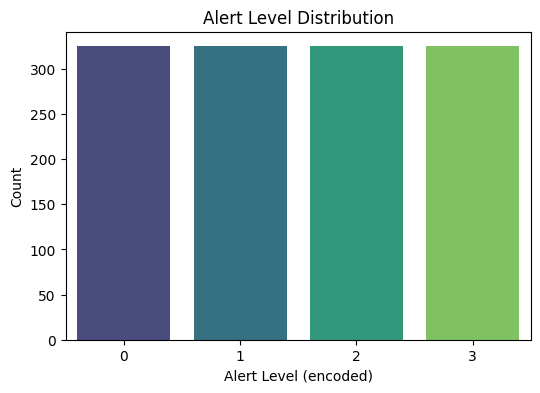

In [6]:
plt.figure(figsize=(6,4))
sns.countplot(x='alert', data=df, palette='viridis')
plt.title('Alert Level Distribution')
plt.xlabel('Alert Level (encoded)')
plt.ylabel('Count')
plt.show()

## Correlation matrix

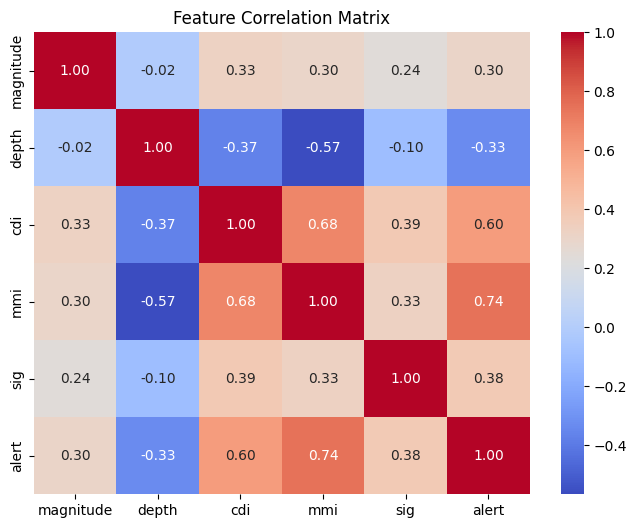

In [7]:
plt.figure(figsize=(8,6))
corr = df[features + [target]].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

## Pairplot

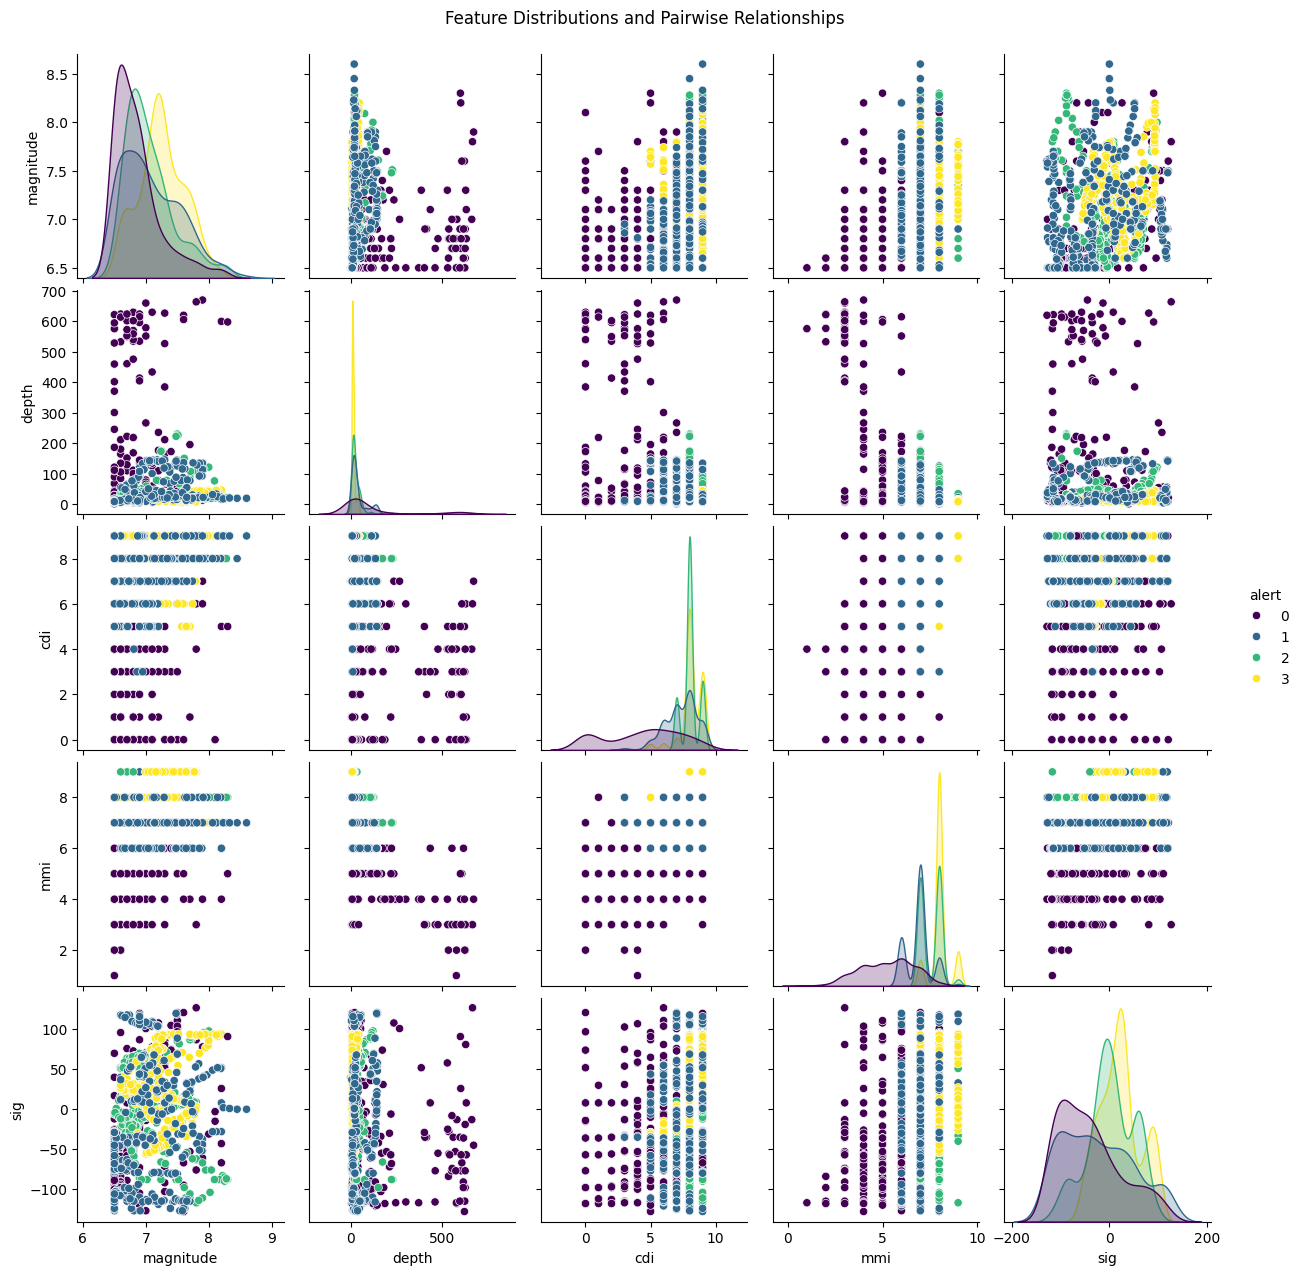

In [8]:
sns.pairplot(df, vars=features, hue='alert', palette='viridis', diag_kind='kde')
plt.suptitle("Feature Distributions and Pairwise Relationships", y=1.02)
plt.show()

## Feature-target relationships

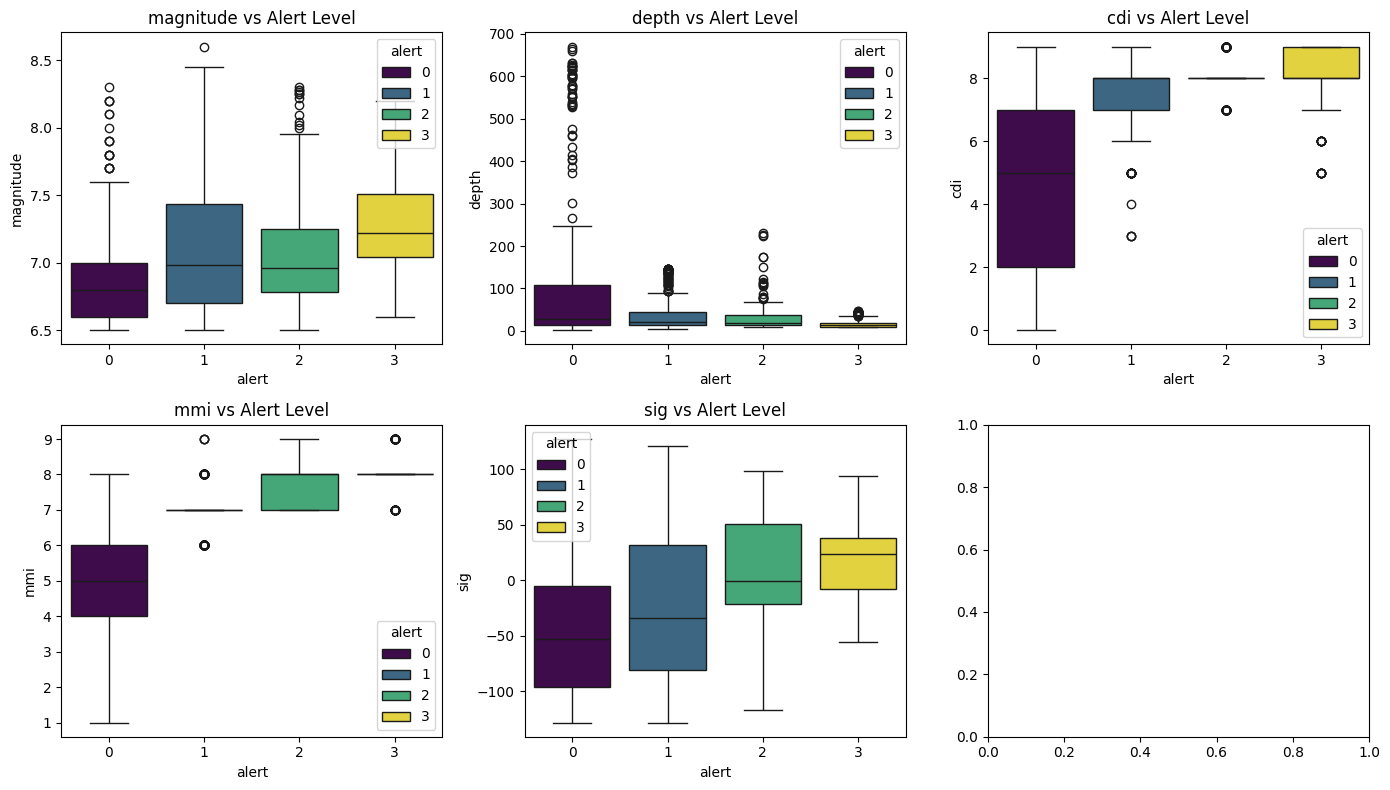

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(14,8))
axs = axs.ravel()

for i, f in enumerate(features):
    sns.boxplot(x='alert', y=f, data=df, palette='viridis', hue='alert', ax=axs[i])
    axs[i].set_title(f'{f} vs Alert Level')

plt.tight_layout()
plt.show()


## PCA

Explained variance ratio (2D): [0.484 0.215]
Total variance explained (2D): 0.699


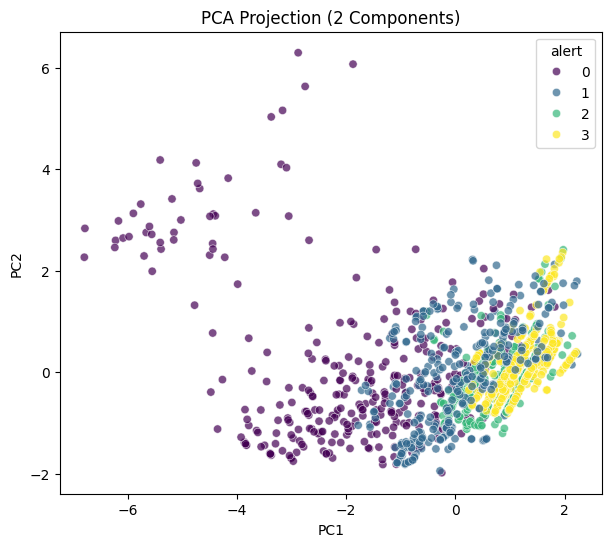

In [10]:
from sklearn.decomposition import PCA

# Standardize the features before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# Perform PCA (reduce to 2 and 3 components for visualization)
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

# Explained variance
print("Explained variance ratio (2D):", np.round(pca_2d.explained_variance_ratio_, 3))
print("Total variance explained (2D):", round(sum(pca_2d.explained_variance_ratio_), 3))

# 2D PCA Scatter
plt.figure(figsize=(7,6))
sns.scatterplot(x=X_pca_2d[:,0], y=X_pca_2d[:,1],
                hue=df['alert'], palette='viridis', alpha=0.7)
plt.title("PCA Projection (2 Components)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


## Observations

- cdi and mmi can provide the best alert separation. Advantage: we can easily isolate alert 0. Issue: too narrow windows between 1-2 and 2-3.

**Conlcusion**: We can separate most of the alert 0s from the other alerts with a single observation (`mmi <= 6 || depth>=250`)

In [11]:
df[(df['depth']>=235)|(df['mmi']<=8)].groupby('alert').size()

alert
0    325
1    322
2    316
3    284
dtype: int64

In [12]:
df.groupby('alert').size()

alert
0    325
1    325
2    325
3    325
dtype: int64

<Axes: xlabel='depth', ylabel='mmi'>

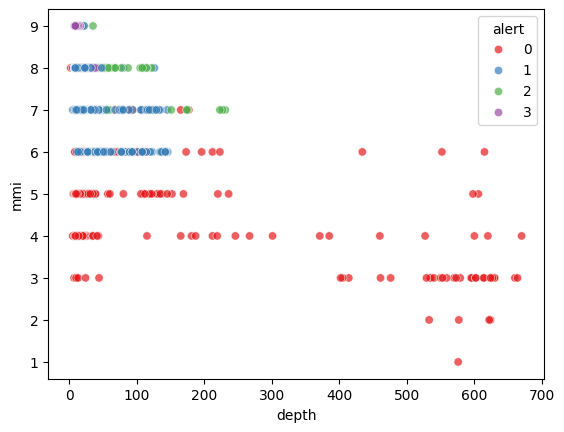

In [13]:
sns.scatterplot(x=df['depth'], y=df['mmi'],
                hue=df['alert'], palette='Set1', alpha=0.7)

## Separating Alert 0

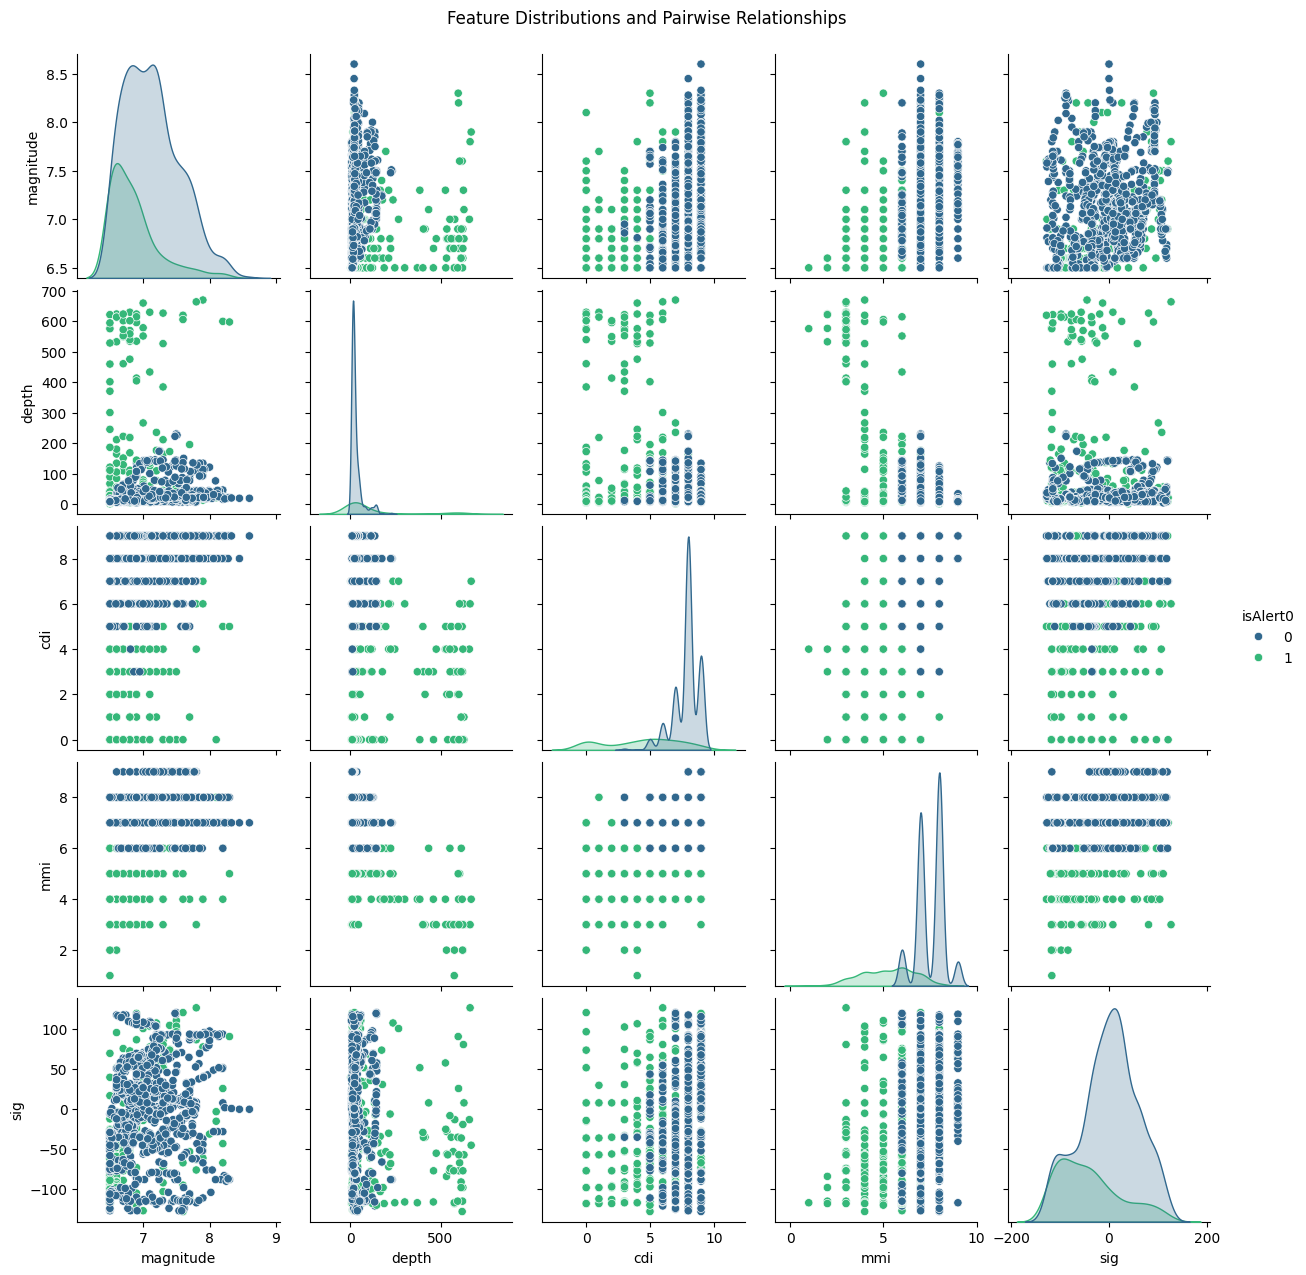

In [14]:
# create a new df where with a new column isAlert0, don't use the same df:
df['isAlert0'] = (df['alert'] == 0).astype(int)

sns.pairplot(df, vars=features, hue='isAlert0', palette='viridis', diag_kind='kde')
plt.suptitle("Feature Distributions and Pairwise Relationships", y=1.02)
plt.show()

We could observe that the best separation is done by the cdi/mmi plot, so let's try fit it

Fitted parameters: [ 1.27983826e-02  1.57367035e-02 -2.48405206e+00 -3.30812500e+00
  2.02357754e-01  1.49130993e-01 -7.33128216e-02  2.42667598e+01
  9.19932093e-01]


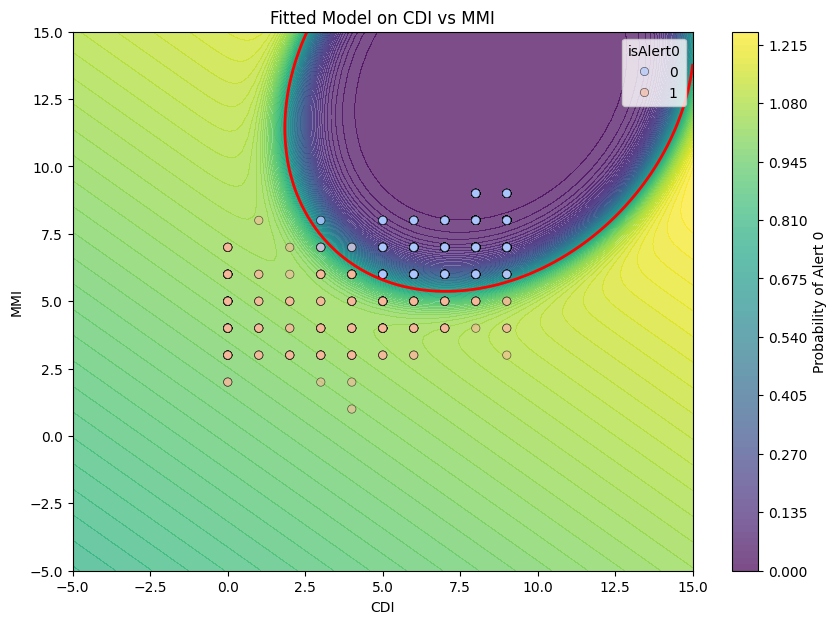

In [15]:
# python: fit on cdi/mmi plot based on isAlert0, regression on f(cdi, mmi) = a1*exp(b1*cdi) + a2*exp(b2*mmi) + c
# code:
from scipy.optimize import curve_fit
def model_func(X, a,b,c,d,e,f,g,h,i):
    cdi, mmi = X
    return (a*cdi+b*mmi+i)/(1+np.exp(-(c*cdi+d*mmi+e*cdi**2+f*mmi**2+g*cdi*mmi+h)))
    
popt, pcov = curve_fit(model_func, (df['cdi'], df['mmi']), df['isAlert0'], p0=(1, -0.1, 1, -0.1, 0, 0,0,0,0), maxfev=20000)
print("Fitted parameters:", popt)
# visuzlize:
cdi_range = np.linspace(-5, 15, 100)
mmi_range = np.linspace(-5, 15, 100)
Cdi, Mmi = np.meshgrid(cdi_range, mmi_range)
Z = model_func((Cdi, Mmi), *popt)
plt.figure(figsize=(10, 7))
contour = plt.contourf(Cdi, Mmi, Z, levels=100, cmap='viridis', alpha=0.7)

plt.colorbar(contour, label='Probability of Alert 0')
sns.scatterplot(x=df['cdi'], y=df['mmi'],
                hue=df['isAlert0'], palette='coolwarm', edgecolor='k', alpha=0.6)

# on top of contour, plot a single contour line at a certain Z value, e.g., 0.5
plt.contour(Cdi, Mmi, Z, levels=[0.7], colors='red', linewidths=2)

plt.title("Fitted Model on CDI vs MMI")
plt.xlabel("CDI")
plt.ylabel("MMI")
plt.xlim(-5,15)
plt.ylim(-5,15)
plt.show()

The condition to isolate Alert0 is:

$ \frac{a*cdi+b*mmi+i}{1+exp(-(c*cdi+d*mmi+e*cdi^2+f*mmi^2+g*cdi*mmi+h))} \ge 0.7 $,

where, $a,\ldots,i$ are the curvefit values from above

In [16]:
def alert0_condition(cdi, mmi):
    pms = [1.27984035e-02,  1.57367417e-02, -2.48405223e+00, -3.30812036e+00,
           2.02357722e-01,  1.49130611e-01, -7.33127329e-02,  2.42667445e+01,
        9.19931899e-01]
    return model_func((cdi, mmi), *pms) >= 0.7  # threshold at 0.7

In [17]:
# now compute the metrics (acc, precision, recall, f1) for alert0_condition on the whole df
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
y_true = df['isAlert0']
y_pred = alert0_condition(df['cdi'], df['mmi']).astype(int)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f"Alert 0 Condition Metrics:\nAccuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1-Score: {f1:.3f}")

Alert 0 Condition Metrics:
Accuracy: 0.918, Precision: 0.995, Recall: 0.674, F1-Score: 0.804


# Filtering Alert0 from the dataset

In [18]:
# create dataframe df1 that contains all non-Alert0 entries
df1 = df[df['alert'] != 0].reset_index(drop=True)
df1.shape, df1['alert'].value_counts()
display(df.describe())

magnitude        depth          cdi          mmi          sig  \
count  1300.000000  1300.000000  1300.000000  1300.000000  1300.000000   
mean      7.061008    50.321538     6.976154     6.939231    -9.749231   
std       0.423738   104.348286     2.244875     1.354774    62.245214   
min       6.500000     2.000000     0.000000     1.000000  -128.000000   
25%       6.700000    12.000000     6.000000     6.000000   -54.000000   
50%       7.000000    19.000000     8.000000     7.000000    -7.000000   
75%       7.300000    38.000000     8.000000     8.000000    31.000000   
max       8.600000   670.000000     9.000000     9.000000   127.000000   

             alert     isAlert0  
count  1300.000000  1300.000000  
mean      1.500000     0.250000  
std       1.118464     0.433179  
min       0.000000     0.000000  
25%       0.750000     0.000000  
50%       1.500000     0.000000  
75%       2.250000     0.250000  
max       3.000000     1.000000

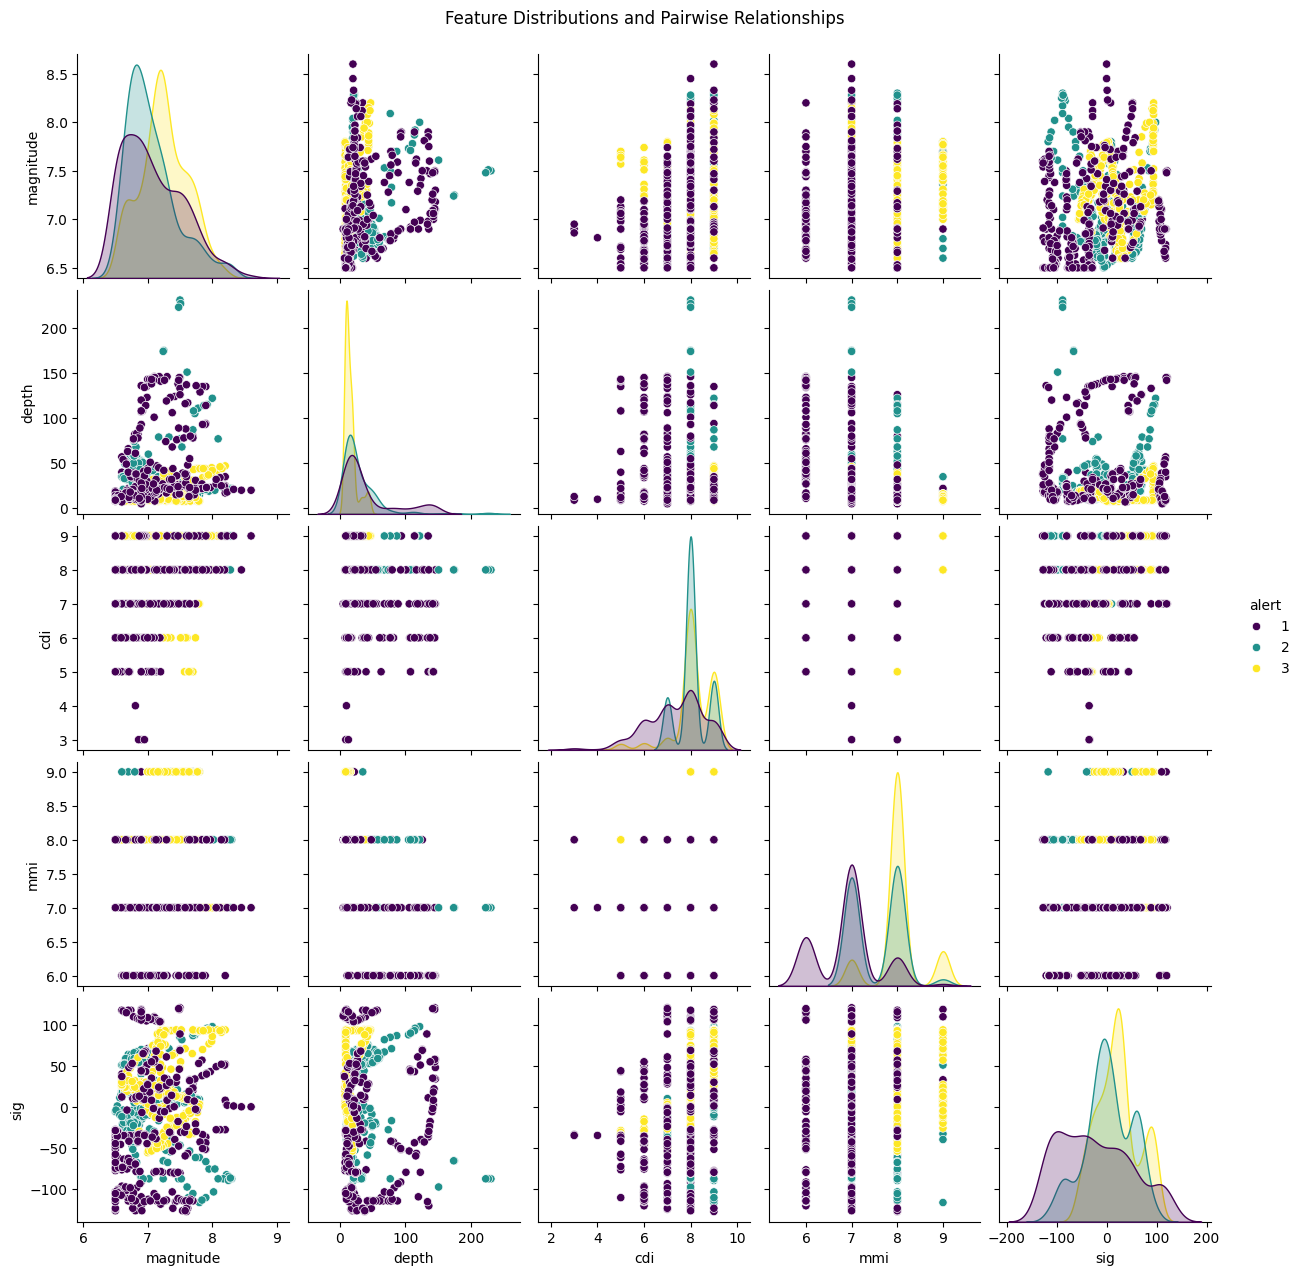

In [19]:
sns.pairplot(df1, vars=features, hue='alert', palette='viridis', diag_kind='kde')
plt.suptitle("Feature Distributions and Pairwise Relationships", y=1.02)
plt.show()

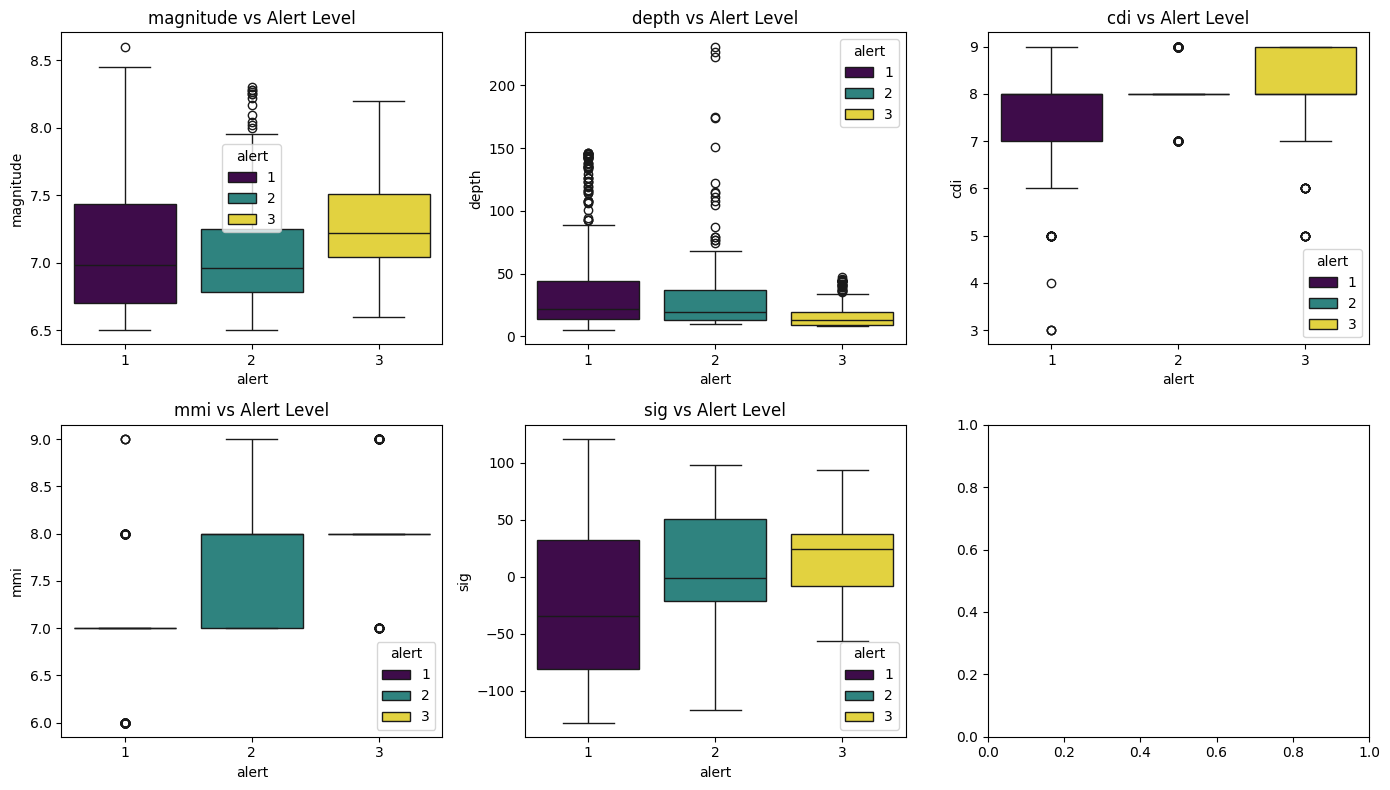

In [20]:
fig, axs = plt.subplots(2, 3, figsize=(14,8))
axs = axs.ravel()

for i, f in enumerate(features):
    sns.boxplot(x='alert', y=f, data=df1, palette='viridis', hue='alert', ax=axs[i])
    axs[i].set_title(f'{f} vs Alert Level')

plt.tight_layout()
plt.show()


Explained variance ratio (2D): [0.372 0.25 ]
Total variance explained (2D): 0.622


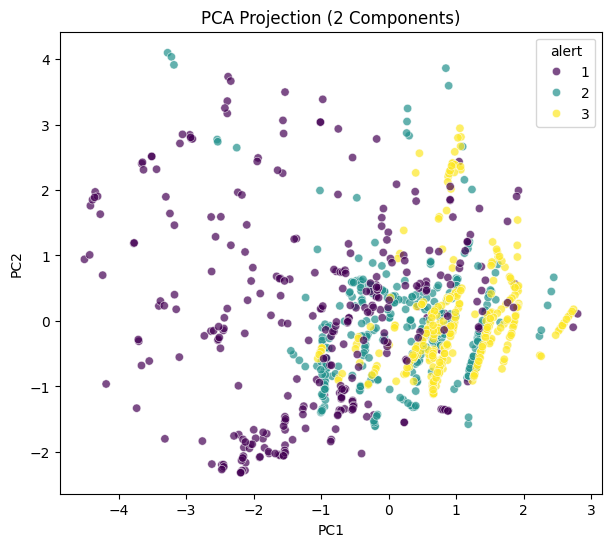

In [21]:
from sklearn.decomposition import PCA

# Standardize the features before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df1[features])

# Perform PCA (reduce to 2 and 3 components for visualization)
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

# Explained variance
print("Explained variance ratio (2D):", np.round(pca_2d.explained_variance_ratio_, 3))
print("Total variance explained (2D):", round(sum(pca_2d.explained_variance_ratio_), 3))

# 2D PCA Scatter
plt.figure(figsize=(7,6))
sns.scatterplot(x=X_pca_2d[:,0], y=X_pca_2d[:,1],
                hue=df1['alert'], palette='viridis', alpha=0.7)
plt.title("PCA Projection (2 Components)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


### Observations

- the measurements alone are not enough to clearly separate any of the remaining alerts
- the cdi/mmi plot looks like it can clearly separate Alert1 from Alert3, but Alert2 must be blended in the other data
- mmi/sig plot has the advantage that all Alert1 points are lower on the y axis than the others, so we might stick to that

<Axes: xlabel='cdi', ylabel='mmi'>

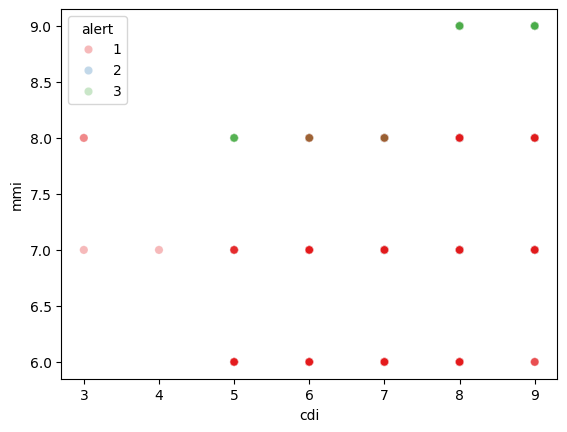

In [22]:
sns.scatterplot(x=df1['cdi'], y=df1['mmi'],
                hue=df1['alert'], palette='Set1', alpha=0.3) 

In [23]:
# dataframes grouped by mmi and cdi, count each alerts
df1.groupby(['mmi', 'cdi'])['alert'].value_counts().unstack(fill_value=0)

alert     1    2    3
mmi cdi              
6.0 5.0  11    0    0
    6.0  27    0    0
    7.0  21    0    0
    8.0  16    0    0
    9.0   4    0    0
7.0 3.0   1    0    0
    4.0   1    0    0
    5.0   7    0    0
    6.0  26    0    0
    7.0  59   43    0
    8.0  74  107    8
    9.0  29    0   23
8.0 3.0   2    0    0
    5.0   0    0    8
    6.0   2    0    9
    7.0   3    8   16
    8.0  21   97  152
    9.0  18   61   68
9.0 8.0   1    3   28
    9.0   2    6   13

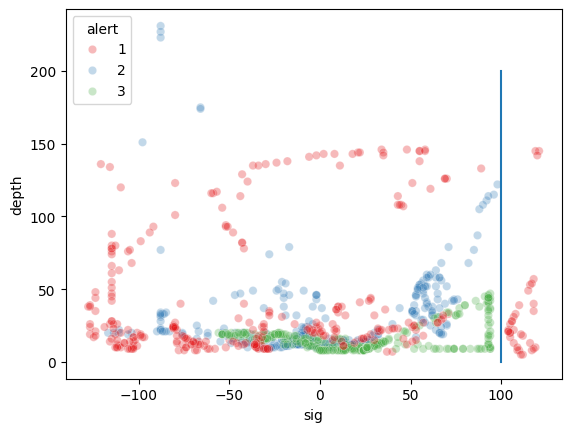

In [24]:
sns.scatterplot(x=df1['sig'], y=df1['depth'], hue=df1['alert'], palette='Set1', alpha=0.3) 
plt.plot([100,100],[0, 200])

We get a valuable condition on how to isolate *some* Alert1 items:
`sig>100 || mmi==6 || (mmi==7 && (cdi<=6))`

Let's filter them out

In [25]:
# df2 = df1 without the rows having mmi==6 || (mmi==7 && (cdi<=6))
df2 = df1[~((df1['sig']>100) | (df1['mmi']==6) | ((df1['mmi']==7) & (df1['cdi']<=6)))].reset_index(drop=True)
df2.shape, df2['alert'].value_counts()

((837, 7),
 alert
 2    325
 3    325
 1    187
 Name: count, dtype: int64)

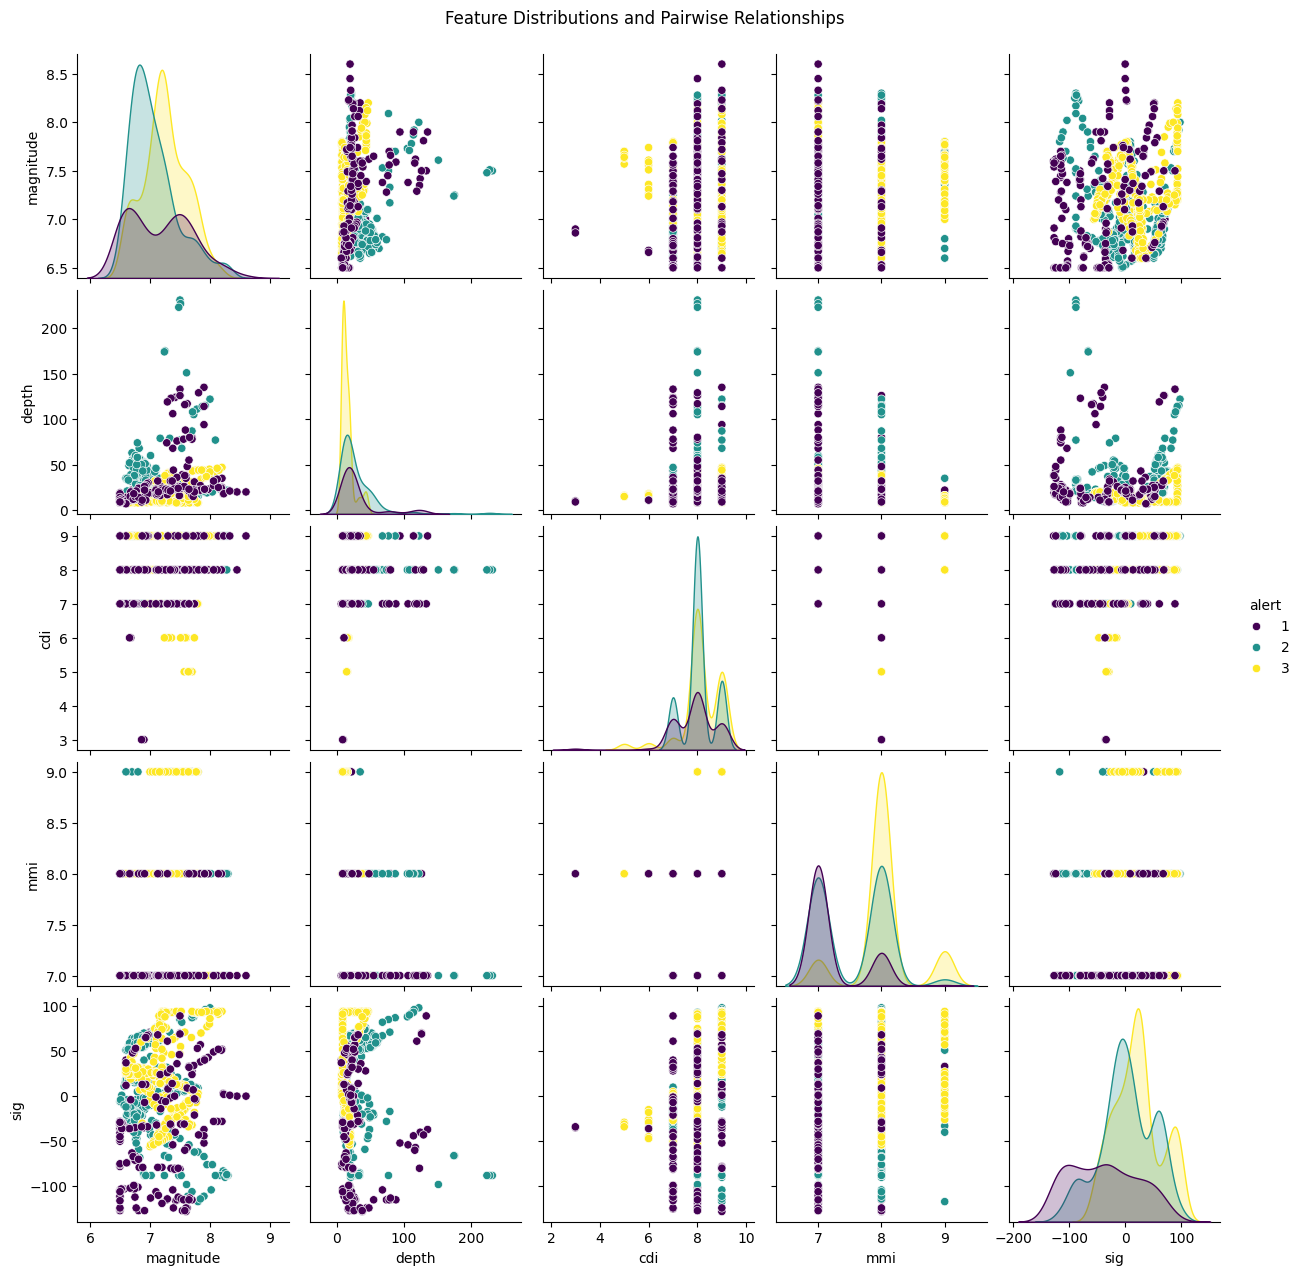

In [26]:
sns.pairplot(df2, vars=features, hue='alert', palette='viridis', diag_kind='kde')
plt.suptitle("Feature Distributions and Pairwise Relationships", y=1.02)
plt.show()

In [27]:
%matplotlib widget

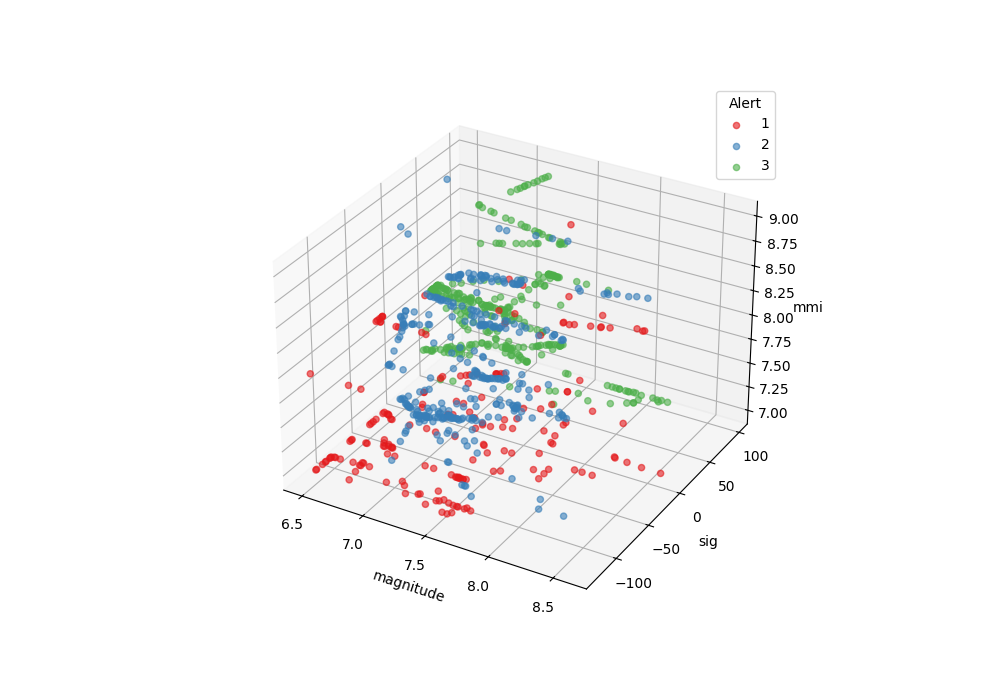

In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#f1, f2, f3 = ['magnitude', 'depth', 'sig']
f1, f2, f3 = ['magnitude', 'sig', 'mmi']

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

colors = plt.get_cmap('Set1')

for i, alert_val in enumerate(df2['alert'].unique()):
    subset = df2[df2['alert'] == alert_val]
    ax.scatter(subset[f1], subset[f2], subset[f3],
               label=alert_val, color=colors(i), alpha=0.6)

ax.set_xlabel(f1)
ax.set_ylabel(f2)
ax.set_zlabel(f3)

ax.legend(title='Alert', loc='best')


plt.show()

Use heuristics per mmi layer:
- mmi=9 => always predict Alert3
- mmi=8 => curve fit Alert2 & Alert3
- mmi=7 => curve fit Alert1 & Alert2

### MMI=7

In [29]:
dfx = df2[(df2['mmi']==7) & (df2['alert']!=3)].reset_index(drop=True)

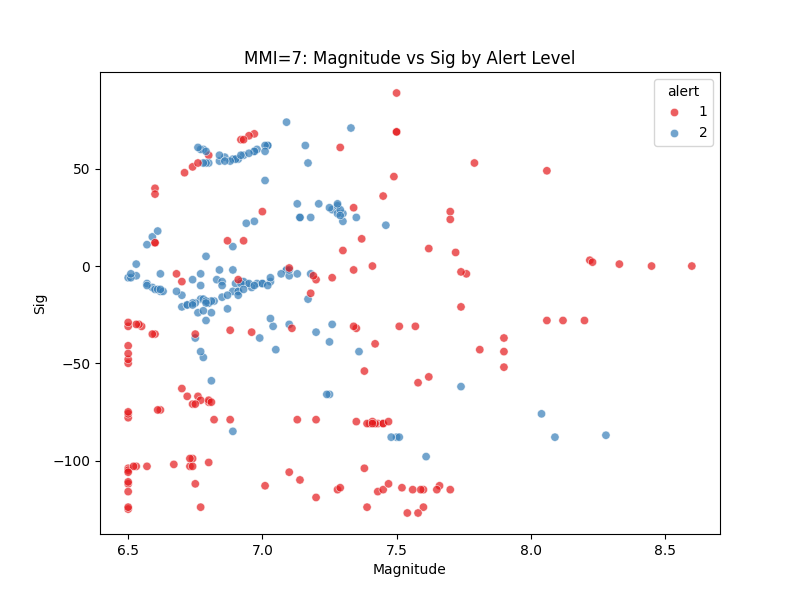

In [30]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=dfx,
    x='magnitude', y='sig',
    hue='alert', palette='Set1', alpha=0.7
)
plt.title("MMI=7: Magnitude vs Sig by Alert Level")
plt.xlabel("Magnitude")
plt.ylabel("Sig")
plt.show()


Fitted parameters: [ 1.08530024e+02 -5.18588843e-01 -7.43785453e+00  1.02482995e-01
  3.94530496e-01 -1.37585339e-05 -1.31901142e-02  2.90637996e+01
 -6.84288504e+02]


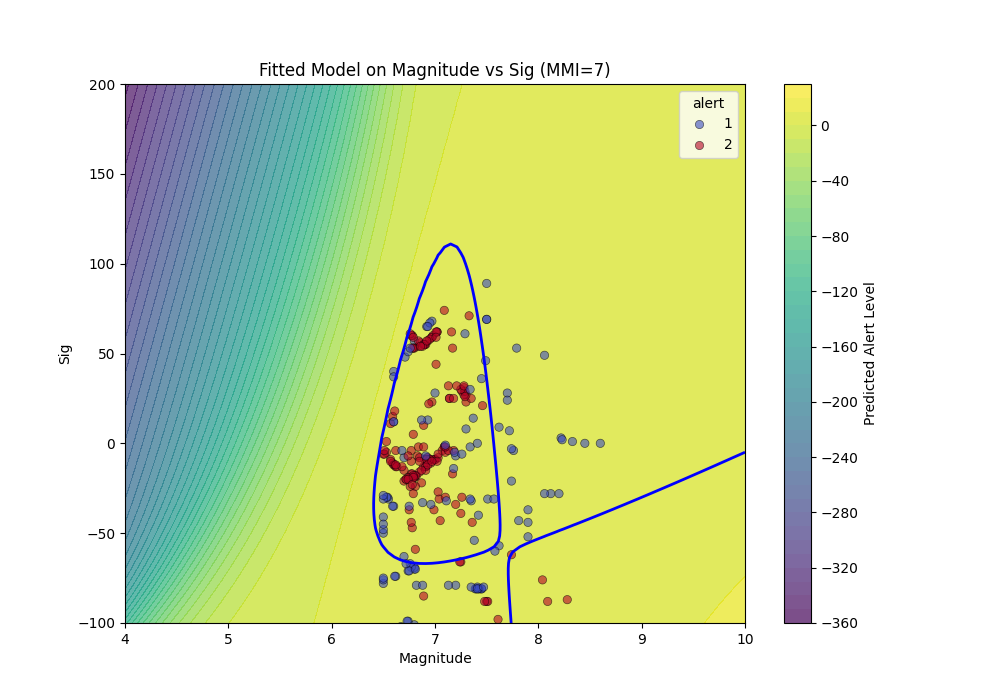

In [31]:
# python: fit on magnitude/sig plot based on alert, regression on f(x,y) = (a*x+b*y+i)/(1+exp(-(c*x+d*y+e*x^2+f*y^2+g*x*y+h)))
# code:
from scipy.optimize import curve_fit
def model_func2(X, a,b,c,d,e,f,g,h,i):
    x, y = X
    return (a*x+b*y+i)/(1+np.exp(-(c*x+d*y+e*x**2+f*y**2+g*x*y+h)))
popt, pcov = curve_fit(model_func2, (dfx['magnitude'], dfx['sig']), dfx['alert'], p0=(1, -0.1, 1, -0.1, 0, 0,0,0,0), maxfev=20000)
print("Fitted parameters:", popt)
# visuzlize:
x_range = np.linspace(4, 10, 100)
y_range = np.linspace(-100, 200, 100)
X, Y = np.meshgrid(x_range, y_range)
Z = model_func2((X, Y), *popt)
plt.figure(figsize=(10, 7))
contour = plt.contourf(X, Y, Z, levels=40, cmap='viridis', alpha=0.7)
plt.colorbar(contour, label='Predicted Alert Level')
sns.scatterplot(x=dfx['magnitude'], y=dfx['sig'],
                hue=dfx['alert'], palette='coolwarm', edgecolor='k', alpha=0.6)
plt.contour(X, Y, Z, levels=[1.325], colors=['blue'], linewidths=2)
plt.title("Fitted Model on Magnitude vs Sig (MMI=7)")
plt.xlabel("Magnitude")
plt.ylabel("Sig")
plt.xlim(x_range.min(),x_range.max())
plt.ylim(y_range.min(),y_range.max())
plt.show()


### MMI=8

In [32]:
dfx = df2[(df2['mmi']==8) & (df2['alert']!=1)].reset_index(drop=True)

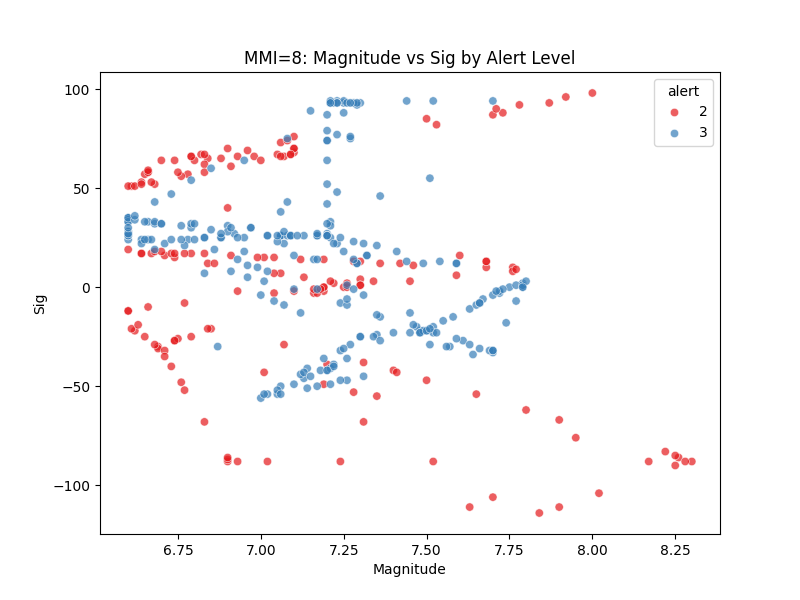

In [33]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=dfx,
    x='magnitude', y='sig',
    hue='alert', palette='Set1', alpha=0.7
)
plt.title("MMI=8: Magnitude vs Sig by Alert Level")
plt.xlabel("Magnitude")
plt.ylabel("Sig")
plt.show()


C:\Users\Stefan\AppData\Local\Temp\ipykernel_7516\1910458911.py:11: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(model_func2, (dfx['magnitude'], dfx['sig']), dfx['alert'], p0=(1, -0.1, 1, -0.1, 0, 0,0,0,0,0), maxfev=20000)


Fitted parameters: [-3.12012780e+02 -3.41873745e+02 -9.15709217e-01 -1.19836149e+01
  8.50046469e+00  4.58161604e-02 -7.13311410e-03 -3.82951563e+00
 -3.57056423e+02  0.00000000e+00]


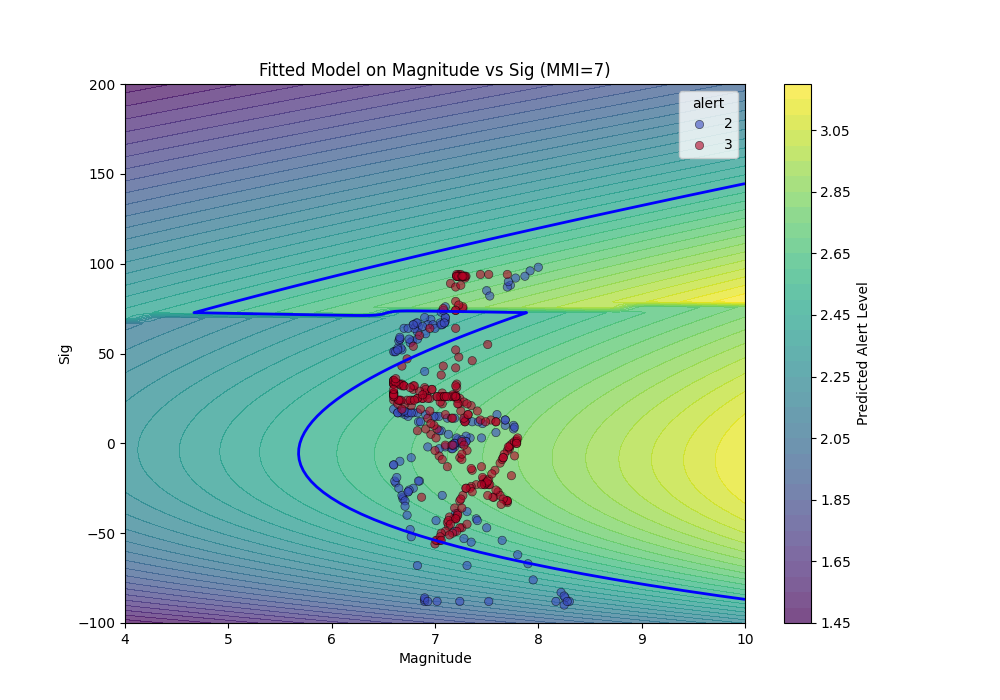

In [34]:
# python: fit on magnitude/sig plot based on alert, regression on f(x,y) = (a*x+b*y+i)/(1+exp(-(c*x+d*y+e*x^2+f*y^2+g*x*y+h)))
# code:
from scipy.optimize import curve_fit
def model_func2(X, a,b,c,d,e,f,g,h,i,j):
    x, y = X
    
    # return ((-(x-a)*np.sin(c)+(y-b)*np.cos(c))-d*np.tanh(e*((x-a)*np.sin(c)+(y-b)*np.cos(c)))+i)/(1+np.exp(-(f*x+g*y+h)))

    return ((-(x-a)*np.sin(c)+(y-b)*np.cos(c))-d*np.tanh(e*((x-a)*np.sin(c)+(y-b)*np.cos(c)))+i)/(1+np.exp(-(f*x+g*y+h)))

popt, pcov = curve_fit(model_func2, (dfx['magnitude'], dfx['sig']), dfx['alert'], p0=(1, -0.1, 1, -0.1, 0, 0,0,0,0,0), maxfev=20000)
print("Fitted parameters:", popt)
# visuzlize:
x_range = np.linspace(4, 10, 100)
y_range = np.linspace(-100, 200, 100)
X, Y = np.meshgrid(x_range, y_range)
Z = model_func2((X, Y), *popt)
plt.figure(figsize=(10, 7))
contour = plt.contourf(X, Y, Z, levels=40, cmap='viridis', alpha=0.7)
plt.colorbar(contour, label='Predicted Alert Level')
sns.scatterplot(x=dfx['magnitude'], y=dfx['sig'],
                hue=dfx['alert'], palette='coolwarm', edgecolor='k', alpha=0.6)
plt.contour(X, Y, Z, levels=[2.5], colors=['blue'], linewidths=2)
plt.title("Fitted Model on Magnitude vs Sig (MMI=7)")
plt.xlabel("Magnitude")
plt.ylabel("Sig")
plt.xlim(x_range.min(),x_range.max())
plt.ylim(y_range.min(),y_range.max())
plt.show()
